# Extract the cutouts

This notebook extract the cutouts and the corresponding noise maps. You can download the data and rerun this notebook, or simply use the cutouts that have already been extracted and pushed on this repo.

Author: [Martin Millon](https://martin-millon.gitlab.io), February 2024.

In [4]:
#parameters (nbreadable)
band = 'f090w'
mas = '40mas'
folder = 'data'

In [5]:
import numpy as np
from astropy.io import fits
import os 
import matplotlib.pyplot as plt

from astropy.nddata import Cutout2D
from astropy.wcs import WCS

In [6]:
if mas == '40mas':
    drizzscale = 0.75
elif mas == '20mas': 
    drizzscale = 0.75

file = os.path.join(folder, f'smacs0723clu-{band}_{mas}_v1p2_drz_sci.fits')
wht = os.path.join(folder,f'smacs0723clu-{band}_{mas}_v1p2_drz_wht.fits')
#CANUC provided rms maps from the Grizzly pipeline. Seems to corresponds to the 1/sqrt(weight_maps) but does not account for the drizzling scale
rms = os.path.join(folder,f'rms_{band}.fits')

hdu = fits.open(file)
data = hdu[0].data
header = hdu[0].header

hdu_wht = fits.open(wht)
exp_map = hdu_wht[0].data
header_wht = hdu_wht[0].header

hdu_rms = fits.open(rms)
rms_map = hdu_rms[0].data
header_rms = hdu_rms[0].header

print(np.shape(data))

(8768, 8768)


In [7]:
def extract_cutout(data, header, x,y, size=(64, 64)):
    wcs = WCS(header=header)
    cutout = Cutout2D(data, (x, y), size, wcs=wcs)
    return cutout



## Stars cutouts extraction

In [8]:
stars_coord = [
                [2277.36,5531.6],
               [2405.52,5315.6],
               [2405.52,5558.96],
               [2372.4,5060.72],
               [2067.12,4988.72],
               [1646.64,5410.64]
               ] 
cutouts = [] 
cutouts_wht = [] 
cutouts_rms = [] 

for s in stars_coord:
    cutouts.append(extract_cutout(data, header, s[0], s[1]))
    cutouts_wht.append(extract_cutout(exp_map, header_wht, s[0], s[1]))
    cutouts_rms.append(extract_cutout(rms_map, header_rms, s[0], s[1]))

n_image = len(cutouts)


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/1953970237.py:3: RuntimeWarning: invalid value encountered in log10
  axes[0, i].imshow(np.log10(c.data), origin='lower')
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/1953970237.py:3: RuntimeWarning: divide by zero encountered in log10
  axes[0, i].imshow(np.log10(c.data), origin='lower')
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/1953970237.py:4: RuntimeWarning: divide by zero encountered in divide
  axes[1, i].imshow(np.sqrt(1/cutouts_wht[i].data * drizzscale**4) , origin='lower')
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/1953970237.py:6: RuntimeWarning: divide by zero encountered in divide
  axes[3, i].imshow(np.sqrt(1/cutouts_wht[i].data * drizzscale**4) - cutouts_rms[i].data, origin='lower')
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/1953970237.py:6: RuntimeWarning: invalid value encountered in subtract
  axes[3, i].imshow(np.sqrt(

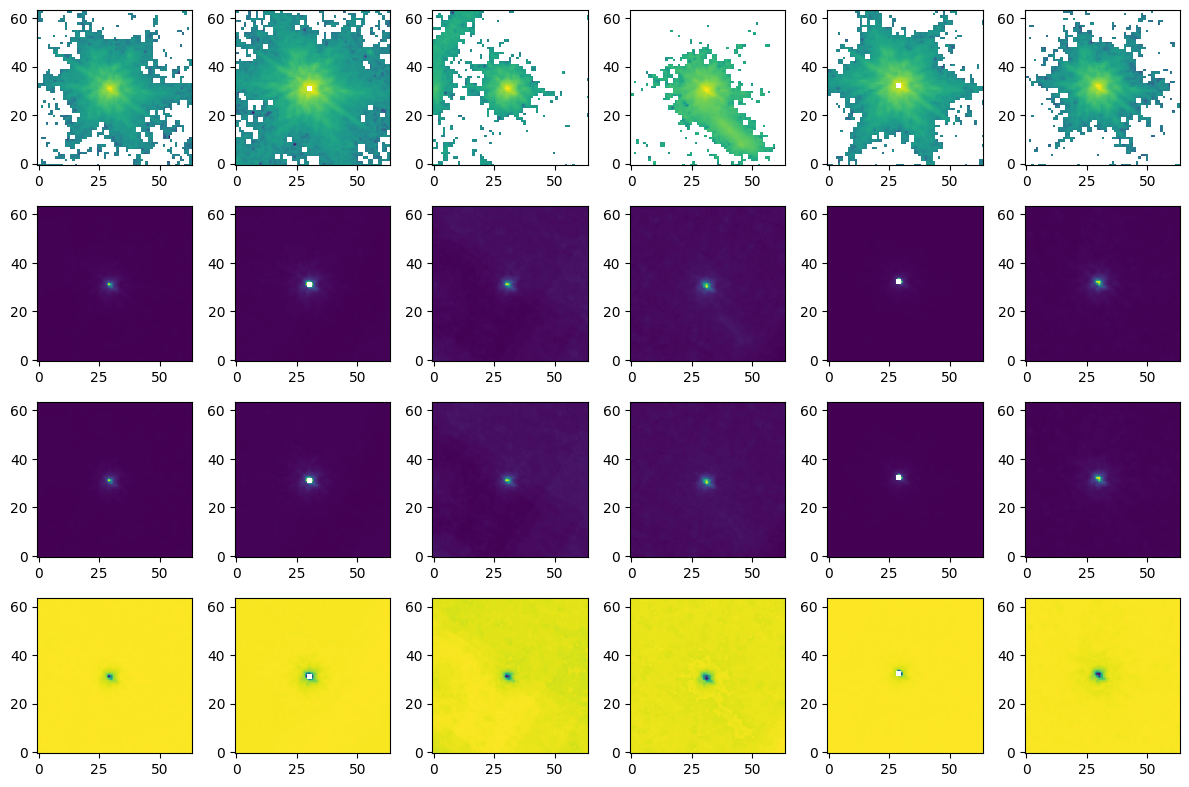

In [9]:
fig, axes = plt.subplots(4, n_image, figsize =(12,8))
for i,c in enumerate(cutouts): 
    axes[0, i].imshow(np.log10(c.data), origin='lower')
    axes[1, i].imshow(np.sqrt(1/cutouts_wht[i].data * drizzscale**4) , origin='lower')
    axes[2, i].imshow(cutouts_rms[i].data, origin='lower')
    axes[3, i].imshow(np.sqrt(1/cutouts_wht[i].data * drizzscale**4) - cutouts_rms[i].data, origin='lower')
    
plt.tight_layout()
plt.show()

Conclusion : weight maps and rms maps are close but not identical.

 **rms = sqrt(1/weight_maps)**

## Noise maps 
We test a naive empirical noise maps estimation to verify that the rms and weight maps have the correct order of magnitude.

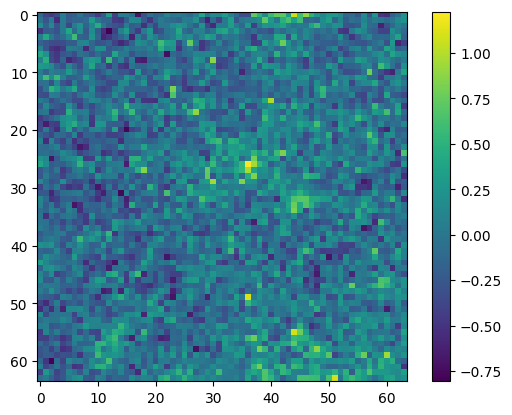

Empirical noise map vs weight maps


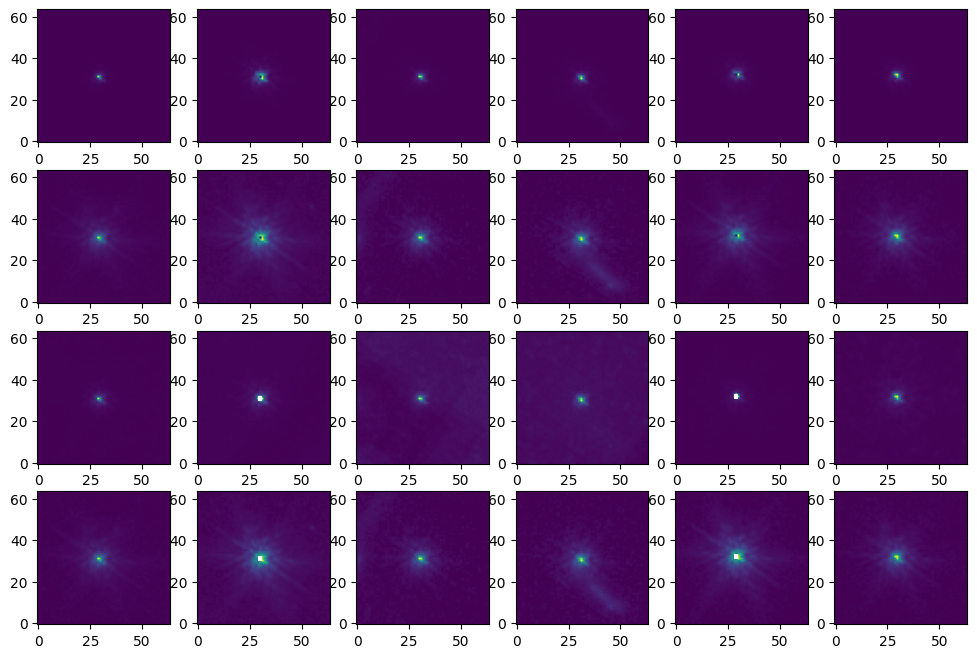

In [10]:
#empirical noise maps
empty = extract_cutout(data, header, 3005, 5798, size=64)
plt.figure()
plt.imshow(empty.data)
plt.colorbar()
plt.show() 

bckg = np.std(empty.data)
sigma_2_empirical = []
for i,c in enumerate(cutouts): 
    im_sizex, im_sizey = np.shape(c.data)
    sigma_2_empirical.append(bckg**2+ c.data.clip(min=0))


sigma_2_empirical = np.asarray(sigma_2_empirical)
print('Empirical noise map vs weight maps')
# weight image to variance conversion is Var = 1 / (W * drizzscale**4) according to 
# https://hst-docs.stsci.edu/drizzpac/chapter-3-description-of-the-drizzle-algorithm/3-3-weight-maps-and-correlated-noise


fig, axes = plt.subplots(4, n_image, figsize =(12,8))
for i in range(n_image): 
    axes[0, i].imshow(cutouts[i].data, origin='lower')
    axes[1, i].imshow(np.sqrt(sigma_2_empirical[i, :, :]), origin='lower')
    axes[2, i].imshow(cutouts_rms[i].data, origin='lower')
    axes[3, i].imshow(np.sqrt(sigma_2_empirical[i, :, :]) - cutouts_rms[i].data, origin='lower')



Conclusion: There is a difference between empirical noise maps and maps computed from the weight image because all pixels does not have the same exposure time. 

Use the iweight_maps.fits = np.sqrt(1 / (cutouts_wht[i].data)) 
or rmsmaps

In [11]:
#saving 1sigma error map

outpath = os.path.join(band, 'stars', mas)
if not os.path.exists(outpath):
    os.makedirs(outpath, exist_ok=True)

for i,c in enumerate(cutouts): 
    he = c.wcs.to_header()
    hdu = fits.PrimaryHDU(c.data, header=he) # we save the data in ADU
    hdu.writeto(os.path.join(outpath ,'star_%i.fits'%i), overwrite=True)

    hdu = fits.PrimaryHDU(np.sqrt(sigma_2_empirical[i]), header=he)
    hdu.writeto(os.path.join(outpath ,'noise_maps_empirical_%i.fits'%i), overwrite=True)

    hdu = fits.PrimaryHDU(cutouts_wht[i].data)
    hdu.writeto(os.path.join(outpath ,'weight_maps_%i.fits'%i), overwrite=True)

    hdu = fits.PrimaryHDU(np.sqrt(1 / (cutouts_wht[i].data * drizzscale**4)))
    hdu.writeto(os.path.join(outpath ,'iweight_maps_%i.fits'%i), overwrite=True)

    hdu = fits.PrimaryHDU(cutouts_rms[i].data)
    hdu.writeto(os.path.join(outpath ,'rms_maps_%i.fits'%i), overwrite=True)


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/3106310779.py:18: RuntimeWarning: divide by zero encountered in divide
  hdu = fits.PrimaryHDU(np.sqrt(1 / (cutouts_wht[i].data * drizzscale**4)))


## extract the Sparkler cutouts

/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_78045/811551276.py:15: RuntimeWarning: invalid value encountered in log10
  ax[0].imshow(np.log10(sparkler.data), origin='lower')


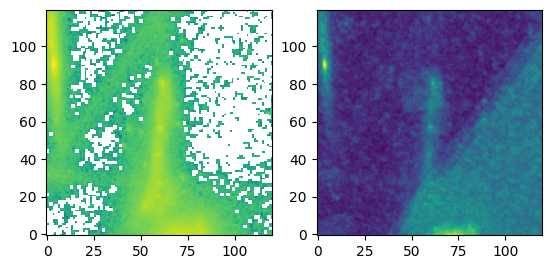

In [12]:
if mas == '40mas':
    x = 2273
    y = 5370
    size = 120
else: 
    x = 4545
    y = 10705
    size = 240

sparkler = extract_cutout(data, header, x,y, size=size)
sparkler_wht = extract_cutout(exp_map, header_wht, x,y, size=size)
sparkler_rms = extract_cutout(rms_map, header_rms, x,y, size=size)

fig_sparkler, ax = plt.subplots(1,2)
ax[0].imshow(np.log10(sparkler.data), origin='lower')
ax[1].imshow(np.log10(sparkler_rms.data), origin='lower')
plt.show()

In [13]:
outpath_s = os.path.join(band, 'science', mas)
if not os.path.exists(outpath_s):
    os.makedirs(outpath_s, exist_ok=True)

he = sparkler.wcs.to_header()
print(he)
hdu = fits.PrimaryHDU(sparkler.data, header = he)
hdu.writeto(os.path.join(outpath_s ,'sparkler.fits'), overwrite=True)

he_wht = sparkler_wht.wcs.to_header()
hdu = fits.PrimaryHDU(sparkler_wht.data, header = he_wht)
hdu.writeto(os.path.join(outpath_s ,'sparkler_weight_map.fits'), overwrite=True)

hdu = fits.PrimaryHDU(np.sqrt(1 / (sparkler_wht.data * drizzscale**2)))
hdu.writeto(os.path.join(outpath_s ,'sparkler_iweight_map.fits'), overwrite=True)

hdu = fits.PrimaryHDU(sparkler_rms.data)
hdu.writeto(os.path.join(outpath_s ,'sparkler_rms_map.fits'), overwrite=True)



WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =                232.5 / Pixel coordinate of reference point            CRPIX2  =                141.5 / Pixel coordinate of reference point            PC1_1   = -1.1111111111111E-05 / Coordinate transformation matrix element       PC2_2   =  1.1111111111111E-05 / Coordinate transformation matrix element       CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               CRVAL1  =            110.83403 / [deg] Coordinate value at reference point      CRVAL2  =            -73.45429 / [deg] C

In [14]:
#save the empty image as well 
hempty = empty.wcs.to_header()
hdu = fits.PrimaryHDU(empty.data, header = hempty)
hdu.writeto(os.path.join(outpath_s ,'empty.fits'), overwrite=True)